
<h1 style="text-align: center; vertical-align: middle;">Model-based optimisation at particle accelerators</h1>
<h2 style="text-align: center; vertical-align: middle;">Use case: Transverse beam steering at ARES linear accelerator at DESY</h2>

<h3 style="text-align: center; vertical-align: middle;">Tutorial at the 3rd Reinforcement Learning for Autonomous Accelerators workshop </h3>   

<h2 style="color: #b51f2a">Getting started</h2>

- You will need **Python 3.12 or higher** to run this code &#x2757;
- You will require about **1 GB of free disk space** &#x2757;
- Make sure you have Git installed in your terminal &#x2757;


Start by cloning locally the repository of the tutorial by running this command in your terminal:

```bash
git clone https://github.com/RL4AA/rl4aa25-tutorial.git
```

<h2 style="color: #b51f2a">Installing virtual environment</h2>

### Using Conda

- If you don't have conda installed already, you can install the `miniconda` as [described here](https://docs.conda.io/projects/miniconda/en/latest/miniconda-install.html).
- We recommend to install `miniconda` the day beforehand to avoid network overload during the tutorial &#x2757; &#x2757;

Once `miniconda` is installed run this command in your terminal:

```bash
conda env create -f environment.yml
```

This should create a virtual environment named `rl25-tutorial` and install the necessary packages inside.

Afterwards, activate the environment using

```bash
conda activate rl25-tutorial
```


<h2 style="color: #b51f2a">Installing virtual environment</h2>

### Using venv

_If you don't have conda installed:_

Alternatively, you can create the virtual env with

```bash
python3 -m venv rl-tutorial
```

and activate the env with `$ source <venv>/bin/activate` (bash) or `C:> <venv>/Scripts/activate.bat` (Windows)

Then, install the packages with `pip` within the activated environment

```bash
python -m pip install -r requirements.txt
```

Afterwards, you should be able to run the provided scripts.

<h2 style="color: #b51f2a">Check your installation</h2>
If you set up your virtual environment correctly and is activated you should be able to run the next cell without any errors:

In [22]:
import sys

sys.path.append("..")

import yaml
import matplotlib.pyplot as plt
import numpy as np
from gymnasium.wrappers import RescaleAction
from IPython.display import clear_output, display, Latex, HTML, Markdown

from src.environments import ea
from src.environments.ea_auxiliary import make_eval_env
from src.utils import evaluate_mae

<h2 style="color: #b51f2a"> ARES (Accelerator Research Experiment at SINBAD)</h2>

ARES is an S-band radio frequency linac at the DESY Hamburg site equipped with a photoinjector and two independently driven traveling wave accelerating structures. The main research focus is the generation and characterization of sub-femtosecond electron bunches at relativistic particle energy. The generation of short electron bunches is of high interest for radiation generation, i.e. by free electron lasers.

<img src="../img/ARES_layout.png" style="width:100%; margin:auto;"/>

- **Final energy**: 100-155 MeV
- **Bunch charge**: 0.01-200 pC
- **Bunch length**: 30 fs - 1 ps
- **Pulse repetition rate**: 1-50 Hz


<h2 style="color: #b51f2a">The accelerator problem we want to solve</h2>

We would like to focus and center the electron beam on a diagnostic screen using corrector and quadrupole magnets

<img src="../img/ares_magnets.png" style="width:70%; margin:auto;"/>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Overview of our study case</h3>
<img src="../img/ares_rl_problem.png" style="width:70%; margin:auto;"/>

<h3 style="color:#038aa1;">Discussion</h3>
<p style="color:#038aa1;"> $\implies$  Is the action space continuous or discrete? </p>
<p style="color:#038aa1;"> $\implies$  Is the problem fully observable or partially observable?</p>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Actions</h3>

<div class="row">
    <div class="column" style="width:60%;float:left">
        <p>In the ARES transverse tuning task we have 3 quadrupoles and 2 corrector magnets</p>
        <p>The actions are:
            <ul>
            <li><b>Quadrupole magnet strength</b> $k_{1,2,3}$ $[1/m^2]$</li>
            <li><b>Corrector deflection angle</b> $\theta_\mathrm{v, h}$ $[mrad]$ (vertical and horizontal</li>
            </ul>
        </p>
        <p>In our control system we can set these derived values directly according the beam energy</p>
        <p>$\implies$ <code>actions</code> $=[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$</p>
            <p>is a 5-dimensional array</p>
    </div>
    <div class="column" style="width:40%;float:right">
        <img src="../img/dipole.png" style="width:50%; margin:auto;"/>
        <img src="../img/quads.png" style="width:35%; margin:auto;"/>
    </div>
</div>


<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Observation / state</h3>

<div class="row">
    <div class="column" style="width:50%;float:left">
        <p>Observation is the information an agent receives about the current state of the environment</p>
        <p>It should provide enough information so that the agent can solve this problem.</p>
        <p>The observation does not necesearily cover the entire (internal) state of the environment.</p>
        <h3 style="color:#038aa1;">Discussion</h3>
        <p style="color:#038aa1;"> $\implies$ What should be included in the <code>observation</code>?  </p>
        <p style="color:#038aa1;"> $\implies$ What can be observed in simulation? </p>
        <p style="color:#038aa1;"> $\implies$ What cannot be observed in real world? </p>
        <p style="color:#038aa1;"> $\implies$ How does this relate to the environment? </p>
    </div>
    <div class="column" style="width:50%;float:right">
      <img src="../img/screen_2.png" style="width:40%; margin:auto;"/>
      <p style="clear:both; font-size: small; text-align: center; margin-top:1em;">
          The screen is made from scintillating material and glows when hit by electrons</p>
      <img src="../img/screen_1.png" style="width:40%; margin:auto;"/>
      <p style="clear:both; font-size: small; text-align: center; margin-top:1em;">The camera films the screen</p>
    </div>
</div>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3> The environment's state</h3>

The `state` can be fully described by with four components:

- The **target beam**: the beam we want to achieve, our goal
  - as a 4-dimensional array $b^\mathrm{(t)}=[\mu_x^{(\mathrm{t})},\sigma_x^{(\mathrm{t})},\mu_y^{(\mathrm{t})},\sigma_y^{(\mathrm{t})}]$, where $\mu$ denotes the position on the screen, $\sigma$ denotes the beam size, and $t$ stands for "target".
- The **incoming beam**: the beam that enters the EA upstream
  - $I = [\mu_x^{(\mathrm{i})},\sigma_x^{(\mathrm{i})},\mu_y^{(\mathrm{i})},\sigma_y^{(\mathrm{i})},\mu_{xp}^{(\mathrm{i})},\sigma_{xp}^{(\mathrm{i})},\mu_{yp}^{(\mathrm{i})},\sigma_{yp}^{(\mathrm{i})},\mu_s^{(\mathrm{i})},\sigma_s^{(\mathrm{i})}]$, where $i$ stands for "incoming"
- The **magnet strengths** and **deflection angles**
  - $[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$
- The **transverse misalignments** of **quadrupoles** and the **diagnostic screen**
  - $[m_{\mathrm{Q1}}^{(\mathrm{x})},m_{\mathrm{Q1}}^{(\mathrm{y})},m_{\mathrm{Q2}}^{(\mathrm{x})},m_{\mathrm{Q2}}^{(\mathrm{y})},m_{\mathrm{Q3}}^{(\mathrm{x})},m_{\mathrm{Q3}}^{(\mathrm{y})},m_{\mathrm{S}}^{(\mathrm{x})},m_{\mathrm{S}}^{(\mathrm{y})}]$

<h3 style="color:#038aa1;">Discussion</h3>
<p style="color:#038aa1;"> $\implies$ Do we (fully) know or can we observe the state of the environment?</p>


<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3> Our definition of observation</h3>

The `observation` for this task contains three parts:

- The **target beam**: the beam we want to achieve, our goal
  - as a 4-dimensional array $b^\mathrm{(t)}=[\mu_x^{(\mathrm{t})},\sigma_x^{(\mathrm{t})},\mu_y^{(\mathrm{t})},\sigma_y^{(\mathrm{t})}]$, where $\mu$ denotes the position on the screen, $\sigma$ denotes the beam size, and $t$ stands for "target".
- The **current beam**: the beam we currently have
  - $b^\mathrm{(c)}=[\mu_x^{(\mathrm{c})},\sigma_x^{(\mathrm{c})},\mu_y^{(\mathrm{c})},\sigma_y^{(\mathrm{c})}]$, where $c$ stands for "current"
- The **magnet strengths** and **deflection angles**
  - $[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$

<h3 style="color:#038aa1;">Discussion</h3>
<p style="color:#038aa1;"> $\implies$ Does this observation definition fullfil the Markov property? (does the probability distribution for the next beam depend only on the observation? or is it affected by other state information?)</p>

<h2 style="color: #b51f2a">Formulating the RL problem</h2>
<h3>Goal and reward</h3>

Our goal is divided in two tasks:

- to **steer** the beam to the desired positions
- to **focus** the beam to the desired beam size

<h2 style="color: #b51f2a">About libraries for RL</h2>

There are many libraries with already implemented RL algorithms, and frameworks to implement an environment to interact with. In this notebook we use:

- [Stable-Baselines3](https://stable-baselines3.readthedocs.io/) for the RL algorithms
- [Gymnasium](https://gymnasium.farama.org/) for the environment
<img src="../img/rl_libraries.png"  style="width:60%; margin:auto;"/>
<p style="clear:both; font-size: small; text-align: center; margin-top:1em;">More info <a href="https://neptune.ai/blog/the-best-tools-for-reinforcement-learning-in-python">here</a></p>

Note:

- Gymnasium is the successor of the [OpenAI Gym](https://www.gymlibrary.dev/).
- Stable-baselines3 now has an early-stage JAX implementation [sbx](https://github.com/araffin/sbx).

<h2 style="color: #b51f2a">Environment</h2>

We take all the elements of the RL problem we defined previously and represent the tuning task as a `gym` environment, which is a standard library for RL tasks.

A custom `gym.Env` would contain the following parts:

- **Initialization**: setup the environment, declares the allowed `observation_space` and `action_space`
- `reset` **method**: resets the environment for a new episode, returns 2-tuple `(observation, info)`
- `step` **method**: main logic of the environment. It takes an `action`, changes the environment to a new `state`, get new `observation`, compute the `reward`, and finally returns the 5-tuple `(observation, reward, terminated, truncated, info)`
  - `terminated` checks if the current episode should be terminated according to the underlying MDP (reached goal reached, or exceeded some thresholds)
  - `truncated` checks if the current episode should be truncated outside of the underlying MD (e.g. time limit)
- `render` **method**: to visualize the environment (a video, or just some plots)

<h2 style="color: #b51f2a">An overview of this RL project</h2>
<img src="../img/ares_ea_rl_technical_setup.png"  style="width:100%; margin:auto;"/>

<h2 style="color: #b51f2a">Code directory structure</h2>

We list the most relevant parts of the project structure below:
--> Edit to match this project

- `utils/train.py` contains the gym environments and the training script
  - `ARESEA` implements the ARES Experimental Area transverse tuning task as a `gym.Env`. It contains the basic logic, such as definition of observation space, action space, and reward. How an action is taken is implemented in child classes with specific backends.
  - `ARESEACheetah` is derived from the base class `ARESEA`, where it uses `cheetah` simulation as a backend.
  - `make_env` Initializes a `ARESEA` envrionment, and wraps it with required [gym.wrappers](https://www.gymlibrary.dev/api/wrappers/) with convenient features (e.g. monitoring the progress, end episode when time_limit is reached, rescales the action, normalize the observation, ...)
  - `train` convenient function for training the RL agent. It calls `make_env`, sets up the RL algorithm, starts training, and saves the results in `utils/recordings`, `utils/monitors` and `utils/models`.

<h2 style="color: #b51f2a">The ARES-EA (ARES Experimental Area) Environment</h2>

- We formulated the ARES-EA task as a `gym` environment, which allows our algorithm to easily interface with both the simulation and real machine backends as shown before.
- In this part, you will get familiar with the environment for the beam focusing and positioning at ARES accelerator.

Some methods:

- `reset`: in both real and simulation cases: resets the magnets to initial values. In simulation, regenerate incoming beam, (optionally) resets the magnet misalignments.
- `step`: set magnets to new settings. Observe the beam (run a simulation or observe screen image in real-world).

Now let's create the environment:

<div style="text-align: center; width:100%;">
    <h1>Part I: the power of standard optimisers</h1>
</div>

Write some text about why we start from here

In [23]:
config = yaml.safe_load(open("../config/ea_eval_config.yaml", "r"))
env = make_eval_env(config, ea)

<h3 style="color:#038aa1;">Set a target beam you want to achieve</h3>
<p style="color:#038aa1;"> $\implies$ Let's define the position $(\mu_x, \mu_y)$ and size $(\sigma_x, \sigma_y)$ of the beam on the screen</p>
<p style="color:#038aa1;"> $\implies$ Modify the <code>target_beam</code> list below, where the order of the arguments is $[\mu_x,\sigma_x,\mu_y,\sigma_y]$</p>
<p style="color:#038aa1;"> $\implies$ Take into account the dimensions of the screen ($\pm$ 2e-3 m)</p>
<p style="color:#038aa1;"> $\implies$ The target beam will be represented by a blue circle on the screen</p>

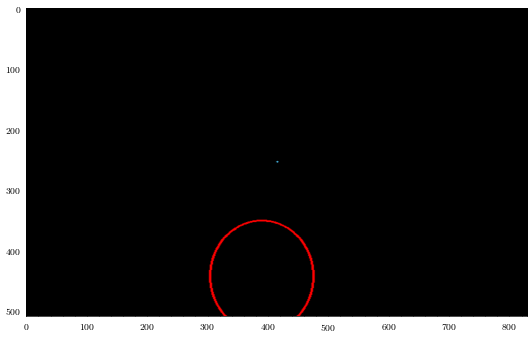

In [ ]:
target_beam = np.array([1e-3, 2e-4, 1e-3, 2e-4])  # Change it
env.target_beam_values = target_beam
env.reset()  ##
plt.figure(figsize=(7, 4))
plt.imshow(env.render())  # Plot the screen image
# Let's improve the rendering to be the same as for RL4AA23

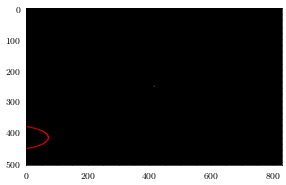

In [27]:
env.reset()
env.unwrapped.get_beam_difference(metric="mae")
plt.imshow(env.unwrapped.render())

## Trying to solve the EA problem

Implement a controller or optimization method, that can bring the observed electron beam $\bm{b}$ to the target beam parameters $\bm{b}'$.

The difference between the beam parameters can be characterized by the mean absolute error (MAE):

$$
d_\text{MAE} (\bm{b}, \bm{b}') = \frac{1}{4} \sum_{i=1}^{4} |\bm{b}_i - \bm{b}'_i|
$$

The algorithm is allowed to interact with the environment for in total $T$ steps. ($T=200$ in this example)

The performance of the method will be evaluated by the following metrics:

- Best MAE achieved by the method $\min d_i, i=1,\dots, T$
- Cumulated MAE differences over the episode $\sum_{i=1}^{T} d_i$

### Baseline Method

To help you get started, below we provide a simple example with the Nelder-Mead optimizer to show how to interact with the env.

In [12]:
# Here we provide the baseline Nelder-Mead simplex Method
from scipy.optimize import minimize


# Wrap the env interaction in an objective function for optimization
def objective(x):
    env.step(x)
    return env.unwrapped.get_beam_difference(metric="mae")


# Reset the Environment
obs, _ = env.reset()

x0 = obs[4:9]

res = minimize(
    objective,
    x0,
    method="nelder-mead",
    options={
        "xatol": 1e-8,
        "disp": True,
        "maxfev": config["env_wrapper"][
            "max_episode_steps"
        ],  # Maximum number of function evaluations
    },
)

/var/folders/88/_4t_28yd5hjdt_chgx6xkj080000gn/T/ipykernel_99507/3673414813.py:16: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(


## Look into the result

Minimum MAE:                0.289  mm
Sum of MAE over all steps:  294.109 mm


(<Figure size 330x250 with 1 Axes>,
 <Axes: xlabel='Step', ylabel='Mean Absolute Error (mm)'>)

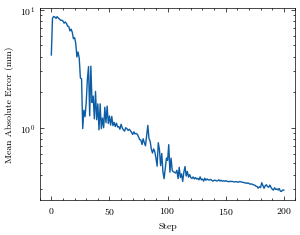

In [13]:
observations = env.get_wrapper_attr("observations")
evaluate_mae(observations)

### Now it is time to develop your own controller!



## Development Ideas:

In the challenge, 

- Have a utility function to prepare the basic env setup (should not be modified) (cheetah backend, magnet range, ...)
  - The users can change the 
  - 
- Create a new env wrapper to log the necessary statistics for the evaluation, e.g.
  - MAEs over steps
  - Wall-time used for each step
- Evaluation Script that runs the control on several tasks and save the results
  - Use argparse to decide which tasks to load, we provide the `train_tasks` in the beginning
  - In the end, we provide the `test_tasks` for the final evaluation
